We'll be trying to predict hause price with regression models.

Let's get started!

# Import libraries

In [292]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns 

from scipy import stats
from scipy.stats import norm, skew #for some statistics

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Checking the datasets

In [293]:
train_df = pd.read_csv("C:/Users/angel/Desktop/Machine Learning Angela/house-prices-advanced-regression-techniques/train.csv")
test_df = pd.read_csv("C:/Users/angel/Desktop/Machine Learning Angela/house-prices-advanced-regression-techniques/test.csv")

In [294]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [295]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
Id               1459 non-null int64
MSSubClass       1459 non-null int64
MSZoning         1455 non-null object
LotFrontage      1232 non-null float64
LotArea          1459 non-null int64
Street           1459 non-null object
Alley            107 non-null object
LotShape         1459 non-null object
LandContour      1459 non-null object
Utilities        1457 non-null object
LotConfig        1459 non-null object
LandSlope        1459 non-null object
Neighborhood     1459 non-null object
Condition1       1459 non-null object
Condition2       1459 non-null object
BldgType         1459 non-null object
HouseStyle       1459 non-null object
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
RoofStyle        1459 non-null object
RoofMatl         1459 non-null object
Exterior1st      1458 non-

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603


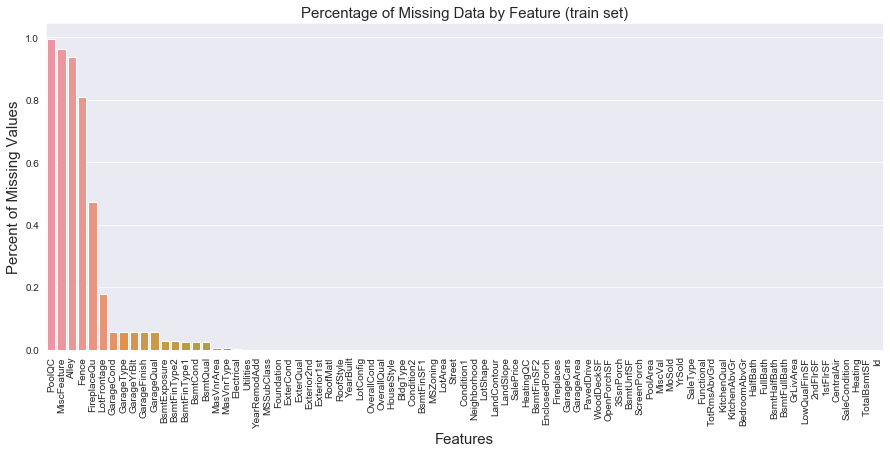

In [296]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of Missing Values', fontsize=15)
plt.title('Percentage of Missing Data by Feature (train set)', fontsize=15)
missing_data.head()

,Total,Percent
PoolQC,1456,0.997944
MiscFeature,1408,0.965045
Alley,1352,0.926662
Fence,1169,0.801234
FireplaceQu,730,0.500343


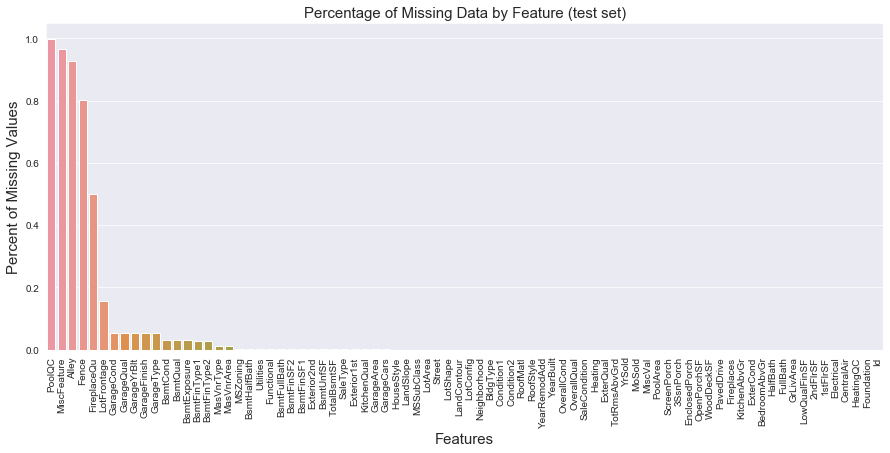

In [297]:
total = test_df.isnull().sum().sort_values(ascending=False)
percent = (test_df.isnull().sum()/test_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of Missing Values', fontsize=15)
plt.title('Percentage of Missing Data by Feature (test set)', fontsize=15)
missing_data.head()

The very first problem is that we have 80 features for prediction. And we have to pick only the important ones.

The second question we must figure out are what to do with lots of missing values.

And finally, we must turn all the 'sting' objects to numeric values.

## Pre-analysis.
First, lets check the SalePrice column to clearly understand the distibution of prices.

In [298]:
train_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Mean price is around 180k USD, the most expensive house is for 775k USD and the cheapest is only for 34,9k USD. 50 quantile lies at 163k USD.

Draw a distribution plot of prices.

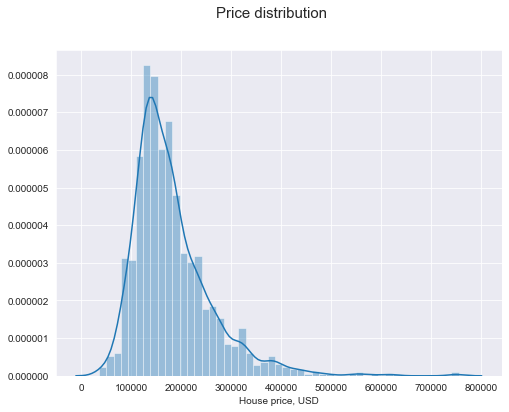

In [299]:
sns.set_style('darkgrid')

fig,ax = plt.subplots(1,1,figsize=(8,6))
sns.distplot(train_df['SalePrice'], ax=ax)

ax.set_xlabel('House price, USD')
plt.suptitle('Price distribution', size=15)
plt.show()


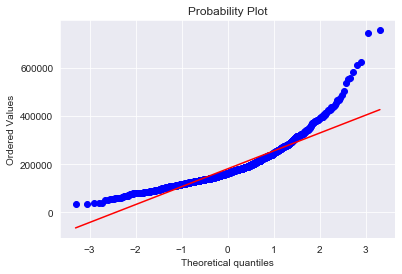

In [300]:
fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

The target variable is right skewed. As (linear) models love normally distributed data , we need to transform this variable and make it more normally distributed.

Log-transformation of the target variable


 mu = 12.02 and sigma = 0.40



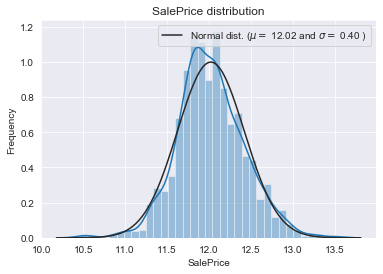

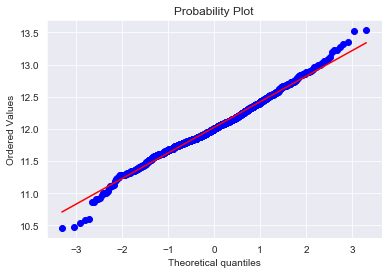

In [301]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])

#Check the new distribution 
sns.distplot(train_df['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()


The skew seems now corrected and the data appears more normally distributed.

Data Correlation

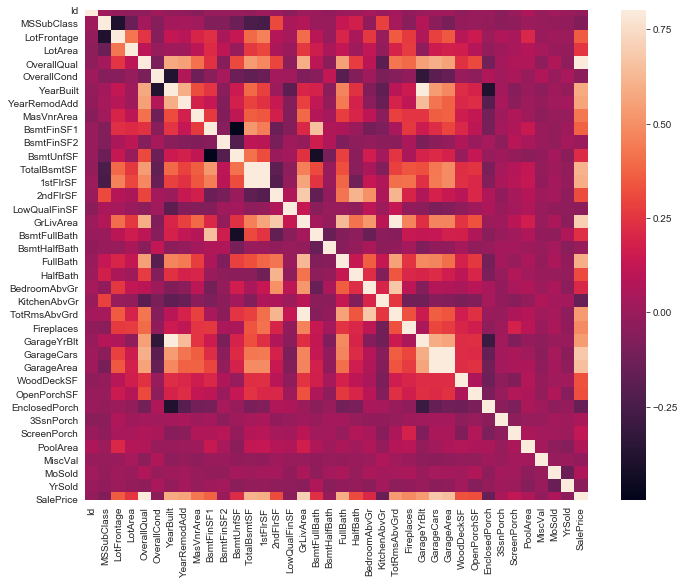

In [302]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

In my opinion, this heat map is the best way to get a quick overview of the relationships between our features.

Let's analyze the correlation between features and the target variable.

In [303]:
train_df.corr()['SalePrice'].sort_values(ascending=False).head(20)

SalePrice       1.000000
OverallQual     0.817185
GrLivArea       0.700927
GarageCars      0.680625
GarageArea      0.650888
TotalBsmtSF     0.612134
1stFlrSF        0.596981
FullBath        0.594771
YearBuilt       0.586570
YearRemodAdd    0.565608
GarageYrBlt     0.541073
TotRmsAbvGrd    0.534422
Fireplaces      0.489450
MasVnrArea      0.430809
BsmtFinSF1      0.372023
LotFrontage     0.355879
WoodDeckSF      0.334135
OpenPorchSF     0.321053
2ndFlrSF        0.319300
HalfBath        0.313982
Name: SalePrice, dtype: float64

In [304]:
# more correlated features
features_correlated = ['SalePrice','OverallQual','GrLivArea',
                       'GarageCars','GarageArea','TotalBsmtSF',
                       '1stFlrSF','FullBath','TotRmsAbvGrd',
                       'YearBuilt','YearRemodAdd']

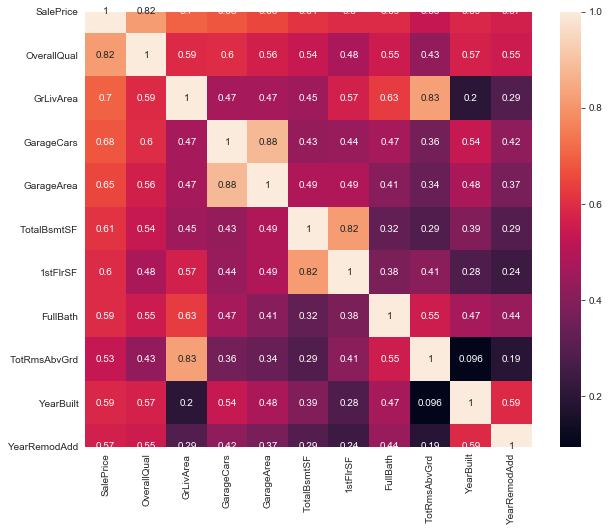

In [305]:
correlated = train_df[features_correlated].corr()
axis = plt.subplots(figsize = (10,8))
sns.heatmap(correlated, annot=True, annot_kws = {"size":10})

# Features engineering

In [306]:
combine = [train_df, test_df]

## Imputing missing values

We impute them by proceeding sequentially through features with missing values



- PoolQC : data description says NA means "No Pool". That make sense, given the huge ratio of missing value (+99%) and majority of houses have no Pool at all in general.


In [307]:
for dataset in combine:
    dataset['PoolQC'] = dataset['PoolQC'].fillna("None")

- MiscFeature : data description says NA means "no misc feature"

In [308]:
for dataset in combine:
    dataset['MiscFeature'] = dataset['MiscFeature'].fillna("None")

- Alley : data description says NA means "no alley access"

In [309]:
for dataset in combine:
     dataset['Alley'] = dataset['Alley'].fillna("None")

- Fence : data description says NA means "no fence"

In [310]:
for dataset in combine:
    dataset['Fence'] = dataset['Fence'].fillna("None")

- FireplaceQu : data description says NA means "no fireplace"


In [311]:
for dataset in combine:
    dataset['FireplaceQu'] = dataset['FireplaceQu'].fillna("None")

- LotFrontage : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.


In [312]:
for dataset in combine:
    dataset['LotFrontage']= dataset.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

- GarageType, GarageFinish, GarageQual and GarageCond : Replacing missing data with None

In [313]:
for dataset in combine:
    for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
        dataset[col] = dataset[col].fillna('None')

- GarageYrBlt, GarageArea and GarageCars : Replacing missing data with 0 (Since No garage = no cars in such garage.)

In [314]:
for dataset in combine:
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        dataset[col] = dataset[col].fillna(0)

- BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath : missing values are likely zero for having no basement

In [315]:
for dataset in combine:
    for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
        dataset[col] = dataset[col].fillna(0)

- BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 : For all these categorical basement-related features, NaN means that there is no basement.

In [316]:
for dataset in combine:
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        dataset[col] = dataset[col].fillna('None')

- MasVnrArea and MasVnrType : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.

In [317]:
for dataset in combine:
    dataset["MasVnrType"] = dataset["MasVnrType"].fillna("None")
    dataset["MasVnrArea"] = dataset["MasVnrArea"].fillna(0)

- MSZoning (The general zoning classification) : 'RL' is by far the most common value. So we can fill in missing values with 'RL'

In [318]:
for dataset in combine:
    dataset['MSZoning'] = dataset['MSZoning'].fillna(dataset['MSZoning'].mode()[0])

- Utilities : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.


In [319]:
for dataset in combine:
    dataset = dataset.drop(['Utilities'], axis=1, inplace=True)

- Functional : data description says NA means typical


In [320]:
for dataset in combine:
    dataset["Functional"] = dataset["Functional"].fillna("Typ")

- Electrical : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.

In [321]:
for dataset in combine:
    dataset['Electrical'] = dataset['Electrical'].fillna(dataset['Electrical'].mode()[0])

- KitchenQual: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.

In [322]:
for dataset in combine:
    dataset['KitchenQual'] = dataset['KitchenQual'].fillna(dataset['KitchenQual'].mode()[0])

- Exterior1st and Exterior2nd : Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string

In [323]:
for dataset in combine:
    dataset['Exterior1st'] = dataset['Exterior1st'].fillna(dataset['Exterior1st'].mode()[0])
    dataset['Exterior2nd'] = dataset['Exterior2nd'].fillna(dataset['Exterior2nd'].mode()[0])

- SaleType : Fill in again with most frequent which is "WD"

In [324]:
for dataset in combine:
    dataset['SaleType'] = dataset['SaleType'].fillna(dataset['SaleType'].mode()[0])

- MSSubClass : Na most likely means No building class. We can replace missing values with None

In [325]:
for dataset in combine:
    dataset['MSSubClass'] = dataset['MSSubClass'].fillna("None")

Is there any remaining missing value ?

In [326]:
#Check remaining missing values if any 
for dataset in combine:
    dataset_na = (dataset.isnull().sum() / len(dataset)) * 100
    dataset_na = dataset_na.drop(dataset_na[dataset_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :dataset_na})
missing_data.head()

,Missing Ratio


It remains no missing value.

## Adding one more important feature

Since area related features are very important to determine house prices, we add one more feature which is the total area of basement, first and second floor areas of each house

In [327]:
# Adding total sqfootage feature 
for dataset in combine:
    dataset['TotalSF'] = dataset['TotalBsmtSF'] + dataset['1stFlrSF'] + dataset['2ndFlrSF']

## Encoding categorical features

Transforming some numerical variables that are really categorical

In [328]:
#MSSubClass=The building class
for dataset in combine:
    dataset['MSSubClass'] = dataset['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
for dataset in combine:
    dataset['OverallCond'] = dataset['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
for dataset in combine:
    dataset['YrSold'] = dataset['YrSold'].astype(str)
    dataset['MoSold'] = dataset['MoSold'].astype(str)

 One hot encoding: getting dummy categorical features

In [329]:
print(train_df.shape)
print(test_df.shape)

(1460, 81)
(1459, 80)


In [330]:
train_df = pd.get_dummies(train_df)
test_df = pd.get_dummies(test_df)

print(train_df.shape)
print(test_df.shape)

(1460, 340)
(1459, 323)


# Model selection

In [331]:
X_train = train_df.drop("SalePrice", axis=1)
y_train = train_df["SalePrice"]
X_test  = test_df

split the training data into training+validation set and test set

In [332]:
##new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(X_train, y_train, test_size=0.30, random_state=42)

In [333]:
X_trainval, new_X_test, y_trainval, new_y_test = train_test_split(X_train, y_train, test_size=0.30, random_state=42)

split train+validation set into training and validation set

In [334]:
new_X_train, X_valid, new_y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=1)

## Linear models for regression

For regression, the general prediction formula for a linear model looks as follows:

y^ = w[0] * x[0] + w[1] * x[1] +....w[p] * x[p] + b

Here, x[0] to x[p] denotes the features of a single data point, w and b are parameters of the model that are learned, and y^ is the prediction the model makes.

For a dataset with a single feature, this is:

y^ = w[0] * x[0] + b

which is known as the equation for a line. Here, w[0] is the slope and b is the y-axis offset.

### Linear regression (aka ordinary least squares)

Linear regression, or ordinary least squares (OLS), is the simplest and most classic linear method fore regression. Linear regression finds the parameters w and b that minimize the mean squared error between predictions and the true regression targets, y, on the training set.
Linear regression has no parameters, which is a benefit, but it also has o way to control model complexity.

In [335]:
lr = LinearRegression().fit(new_X_train, new_y_train)

print("Training set score: {:.2f}".format(lr.score(new_X_train, new_y_train)))
print("Validation set score: {:.2f}".format(lr.score(X_valid, y_valid)))

Training set score: 0.96
Validation set score: 0.74


### Ridge regression

Ridge regression is also a linear model for regression, so the formula it uses to make predictions is the same one used for ordinary least squares. 

In ridge regression, though, the coefficients (w) are chosen not only so that they predict well on the training data, but also to fit an additional constraint. 

We also want the magnitude of coefficients to be as small as possible. Intuitively, this means each feature should have as little effect on the outcome as possible, while still predicting well.

This constraint is an example of what is called "regularization". Regularization means explicitly restricting a model to avoid overfitting.
The particular kind used by ridge regression is known as L2 regularization.

In [336]:
ridge = Ridge().fit(new_X_train, new_y_train)

print("Training set score: {:.2f}".format(ridge.score(new_X_train, new_y_train)))
print("Validation set score: {:.2f}".format(ridge.score(X_valid, y_valid)))

Training set score: 0.95
Validation set score: 0.79


As you can see, the training set score of Ridge is lower than for LinearRegression, while the validation set score is higher.
Ridge is a more restricted model, so we are less likely to overfit.

A less complex model means worse performance on the training set, but better generalization.

The Ridge model makes a trade-off between the semplicity of the model (near-zero coefficients)and its performance on the training set. How much importance the model places on semplicity versus training set performance can be specified by the user, using the alpha parameter.

In the previous example, we used the default parameter alpha=1.0.

The optimum setting of alpha depends on the particular dataset we are using.

Increasing alpha forces coefficients to move more toward zero, which decreases training set performance but might help generalization. 
For example:

In [337]:
ridge10 = Ridge(alpha=10).fit(new_X_train, new_y_train)

print("Training set score: {:.2f}".format(ridge10.score(new_X_train, new_y_train)))
print("Validation set score: {:.2f}".format(ridge10.score(X_valid, y_valid)))

Training set score: 0.94
Validation set score: 0.81


Decreasing alpha allows the coefficients to be less restricted.
For very small values of alpha, coefficients are barely restricted at all, and we end up with a model that resembles LinearRegression:

In [338]:
ridge01 = Ridge(alpha=0.1).fit(new_X_train, new_y_train)

print("Training set score: {:.2f}".format(ridge01.score(new_X_train, new_y_train)))
print("Validation set score: {:.2f}".format(ridge01.score(X_valid, y_valid)))

Training set score: 0.95
Validation set score: 0.76


Here, alpha=10 seems to be working well.
We could try decreasing alpha even more to improve generalization.

### Lasso

An alternative to Ridge for regularization linear regression is Lasso. 
As with ridge regression, the lasso also restricts coefficients to be close to zero, but in a slightly different way, called L1 regularization.

The consequence of L1 regularization is that when using the lasso, some coefficients are exactly zero. This means some features are entirely ignored by the model. This can be seen as a form of automatic feature selection.
Having some coefficients be exactly zero often makes a model easier to interpret, and can reveal the most important features of your model.

In [339]:
lasso = Lasso().fit(new_X_train, new_y_train)

print("Training set score: {:.2f}".format(lasso.score(new_X_train, new_y_train)))
print("Validation set score: {:.2f}".format(lasso.score(X_valid, y_valid)))
print("Number of features used:", np.sum(lasso.coef_ != 0))

Training set score: 0.79
Validation set score: 0.54
Number of features used: 14


As you can see, Lasso does quite badly, both on the training and the validation set. This indicates that we are underfitting.

Similary to Ridge, the Lasso also has a regularization parameter, alpha, that controls how strongly coefficients are pushed toward zero.

In the previous example, we used the default of alpha=1.0. To reduce underfitting, let's try decreasing alpha.

In [357]:
lasso001 = Lasso(alpha=0.01, max_iter=100000).fit(new_X_train, new_y_train)

print("Training set score: {:.2f}".format(lasso001.score(new_X_train, new_y_train)))
print("Validation set score: {:.2f}".format(lasso001.score(X_valid, y_valid)))
print("Number of features used:", np.sum(lasso001.coef_ != 0))

Training set score: 0.86
Validation set score: 0.67
Number of features used: 27


A lower alpha allowed us to fit a more complex model, which worked better on the training and test data.

If we set alpha too low, however, we again remove the effect of regularization.

In practice, Ridge regression is usually the first choice between these two models. However, if you have a large amount of features and expect only a few of them to be important, Lasso might be a better choice.

CONCLUSION: In this case, Ridge would appear to have the best performance among all the linear models for  regression.

## k-Nearest Neighbors

K-nearest neighbors is probably the simplest widely used model conceptually. 
It's easy to implement and understand: building the model consist only of storing the training dataset. To make a prediction for a new data point, the algorithm finds the closest data points in the training dataset (its "nearest neighbors").

The k-NN algorithm assumes that similar things exist in close proximity. K-nn captures the idea of similarity calculating the distance between points on a graph. 
There are different ways of calculating distance, however the straight-line distance (also called the Euclidean distance) is a popular choice.

The prediction using a single neighnor is just the target value of the nearest neighbor.
When using multiple nearest neighbors, the prediction is the average, or mean of the relevant neighbors.

The choice of the parameter K is very crucial: using few neighbors corresponds to high model complexity, and using many neighbors corresponds to low model complexity.

In [341]:
reg = KNeighborsRegressor(n_neighbors=3)
knn = reg.fit(new_X_train, new_y_train)

print("Training set score: {:.2f}".format(knn.score(new_X_train, new_y_train)))
print("Validation set score: {:.2f}".format(knn.score(X_valid, y_valid)))

Training set score: 0.81
Validation set score: 0.63


To select the k that's right for our data, we run the k-NN algorithm several times with different values of k.

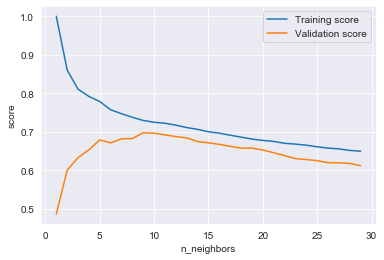

In [342]:
training_score = []
validation_score = []
# try n_neighbors from 1 to 30
neighbors_settings = range (1, 30)

for n_neighbors in neighbors_settings:
    # build the model
    knn = KNeighborsRegressor(n_neighbors=n_neighbors)
    knn.fit(new_X_train, new_y_train)
    # record training set score
    training_score.append(knn.score(new_X_train, new_y_train))
    # record generalization score
    validation_score.append(knn.score(X_valid, y_valid))
        
plt.plot(neighbors_settings, training_score, label='Training score')
plt.plot(neighbors_settings, validation_score, label='Validation score')

plt.ylabel('score')
plt.xlabel('n_neighbors')
plt.legend()

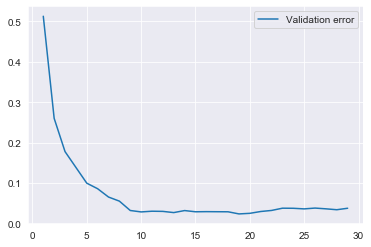

In [343]:
plt.plot(neighbors_settings, np.array(training_score) - np.array(validation_score), label='Validation error')
plt.legend()

Grid Search with cross-validation is a smart way to find out the optimal k value:

In [344]:
param_grid = {'n_neighbors' : np.arange(1,30)}
knn = KNeighborsRegressor()
knn_cv = GridSearchCV(knn, param_grid, cv=5)
knn_cv.fit(new_X_train, new_y_train)
print("Best parameter:{}".format(knn_cv.best_params_))
print("Best cross-validation score: {:.2f}".format(knn_cv.best_score_))

Best parameter:{'n_neighbors': 8}
Best cross-validation score: 0.65


In [358]:
reg = KNeighborsRegressor(n_neighbors=8)
knn = reg.fit(new_X_train, new_y_train)

print("Training set score: {:.2f}".format(knn.score(new_X_train, new_y_train)))
print("Validation set score: {:.2f}".format(knn.score(X_valid, y_valid)))

Training set score: 0.74
Validation set score: 0.68


## Decision Trees

Decision Trees are ML algorithms that progressively divide data sets into smaller data groups based on a descriptive feature, until they reach sets that are small enough to be described by some label. They require that you have data that is labeled (tagged with one or more labels, like the plant name in pictures of plants), so they try to label new data based on that knowledge.

DTs are composed of nodes, branches, and leaves. Each node represents an attribute (or feature), each branch represents a rule (or decision), and each leaf represents an outcome. The depth of a Tree is defined by the number of levels, not including the root node.

DTs apply a top-down approach to data, so that given a data set, they try to group and label observations that are similar between them, and look for the best rules that split the observations that are dissimilar between them until they reach a certain degree of similarity.

A common technique used for splitting is Recursive Binary Splitting. In this procedure all the feature are considered and different split points are tried and tested using a cost function. The split with the best cost (or lowest cost) is selected.

Let's apply the DecisionTreeRegressor to our data now: 

In [346]:
tree = DecisionTreeRegressor().fit(new_X_train, new_y_train)

print("Training set score: {:.2f}".format(tree.score(new_X_train, new_y_train)))
print("Validation set score: {:.2f}".format(tree.score(X_valid, y_valid)))

Training set score: 1.00
Validation set score: 0.70


In general, the deeper you allow your tree to grow, the more complex your model will become because you will have more splits and it captures more information about the data and this is one of the root causes of overfitting in decision trees because your model will fit perfectly for the training data and will not be able to generalize well on test set. So, if your model is overfitting, reducing the number for max_depth is one way to combat overfitting.

In [364]:
tree = DecisionTreeRegressor(max_depth=3).fit(new_X_train, new_y_train)

print("Training set score: {:.2f}".format(tree.score(new_X_train, new_y_train)))
print("Validation set score: {:.2f}".format(tree.score(X_valid, y_valid)))

Training set score: 0.75
Validation set score: 0.69


It is also bad to have a very low depth because your model might will underfit.

In [362]:
tree = DecisionTreeRegressor(max_depth=9).fit(new_X_train, new_y_train)

print("Training set score: {:.2f}".format(tree.score(new_X_train, new_y_train)))
print("Validation set score: {:.2f}".format(tree.score(X_valid, y_valid)))

Training set score: 0.98
Validation set score: 0.74


So what I usually do is, let the model decide the max_depth first and then by comparing my train and test scores I look for overfitting or underfitting and depending on the degree I decrease or increase the max_depth.

## Random Forest

A Random Forest is an ensemble technique capable of performing both regression and classification tasks with the use of multiple decision trees and a technique called Bootstrap Aggregation, commonly known as bagging. 

Bagging, in the Random Forest method, involves training each decision tree on a different data sample where sampling is done with replacement.

The basic idea behind this is to combine multiple decision trees in determining the final output rather than relying on individual decision trees.

To build a random forest model, you need to decide on the number of trees to build (the n_estrimator parameter of RandomForestRegressor or RandomForestClassifier). These trees will be built completely independently from each other, and the algorithm will make different random choices for each tree to make sure the trees are distinct.
To make a prediction, the algorithm first makes a prediction for every tree in the forest. Then, for regression problems we can average these results to get our final prediction.

In [349]:
forest = RandomForestRegressor(n_estimators=5).fit(new_X_train, new_y_train)

print("Training set score: {:.2f}".format(forest.score(new_X_train, new_y_train)))
print("Validation set score: {:.2f}".format(forest.score(X_valid, y_valid)))

Training set score: 0.96
Validation set score: 0.83


We are using the grid search cross validation method from the sklearn library to determine the optimal values to be used for the hyperparameters of our model from a specified range of values. 

Here, we have chosen max_depth and n_estimators to be optimized. According to sklearn documentation, max_depth refers to the maximum depth of the tree and n_estimators, the number of trees in the forest.

In [350]:
#param_grid = {'n_estimators' : np.arange(5,50,5), 'max_depth' : np.arange(3,15)}
#forest = RandomForestRegressor()
#forest_cv = GridSearchCV(forest, param_grid, cv=3)
#forest_cv.fit(new_X_train, new_y_train)
#print("Best parameter:{}".format(forest_cv.best_params_))
#print("Best cross-validation score: {:.2f}".format(forest_cv.best_score_))

In [351]:
forest = RandomForestRegressor(n_estimators=40, max_depth=13).fit(new_X_train, new_y_train)

print("Training set score: {:.2f}".format(forest.score(new_X_train, new_y_train)))
print("Validation set score: {:.2f}".format(forest.score(X_valid, y_valid)))

Training set score: 0.98
Validation set score: 0.85


In [352]:
#param_grid = {'n_estimators' : np.arange(10,100,10), 'max_depth' : np.arange(3,15)}
#forest = RandomForestRegressor()
#forest_cv = GridSearchCV(forest, param_grid, cv=3)
#forest_cv.fit(new_X_train, new_y_train)
#print("Best parameter:{}".format(forest_cv.best_params_))
#print("Best cross-validation score: {:.2f}".format(forest_cv.best_score_))

In [353]:
forest = RandomForestRegressor(n_estimators=50, max_depth=11).fit(new_X_train, new_y_train)

print("Training set score: {:.2f}".format(forest.score(new_X_train, new_y_train)))
print("Validation set score: {:.2f}".format(forest.score(X_valid, y_valid)))

Training set score: 0.98
Validation set score: 0.85


In [354]:
#param_grid = {'n_estimators' : np.arange(100,300,50), 'max_depth' : np.arange(11,21,2)}
#forest = RandomForestRegressor()
#forest_cv = GridSearchCV(forest, param_grid, cv=3)
#forest_cv.fit(new_X_train, new_y_train)
#print("Best parameter:{}".format(forest_cv.best_params_))
#print("Best cross-validation score: {:.2f}".format(forest_cv.best_score_))

In [355]:
forest = RandomForestRegressor(n_estimators=150, max_depth=15).fit(new_X_train, new_y_train)

print("Training set score: {:.2f}".format(forest.score(new_X_train, new_y_train)))
print("Validation set score: {:.2f}".format(forest.score(X_valid, y_valid)))

Training set score: 0.98
Validation set score: 0.85


# Conclusion

Let's train the different tuned models on the whole training set and test them on the real test set.

In [374]:
# Logistic regression (OLS)

lr = LinearRegression().fit(X_trainval, y_trainval)
y_pred = lr.predict(new_X_test)

print("Trainval set score: {:.2f}".format(lr.score(X_trainval, y_trainval)))
print("Test set score: {:.2f}".format(lr.score(new_X_test, new_y_test)))

Trainval set score: 0.95
Test set score: 0.88


In [375]:
# Ridge

ridge10 = Ridge(alpha=10).fit(X_trainval, y_trainval)
y_pred = ridge10.predict(new_X_test)

print("Trainval set score: {:.2f}".format(ridge10.score(X_trainval, y_trainval)))
print("Test set score: {:.2f}".format(ridge10.score(new_X_test, new_y_test)))

Trainval set score: 0.93
Test set score: 0.89


In [376]:
# Lasso

lasso001 = Lasso(alpha=0.01, max_iter=100000).fit(X_trainval, y_trainval)
y_pred = lasso001.predict(new_X_test)

print("Trainval set score: {:.2f}".format(lasso001.score(X_trainval, y_trainval)))
print("Test set score: {:.2f}".format(lasso001.score(new_X_test, new_y_test)))

Trainval set score: 0.84
Test set score: 0.85


In [377]:
# k-NN

knn = KNeighborsRegressor(n_neighbors=8).fit(X_trainval, y_trainval)
y_pred = knn.predict(new_X_test)

print("Trainval set score: {:.2f}".format(knn.score(X_trainval, y_trainval)))
print("Test set score: {:.2f}".format(knn.score(new_X_test, new_y_test)))

Trainval set score: 0.75
Test set score: 0.69


In [378]:
# Decision Tree

tree = DecisionTreeRegressor(max_depth=9).fit(X_trainval, y_trainval)
y_pred = tree.predict(new_X_test)

print("Trainval set score: {:.2f}".format(tree.score(X_trainval, y_trainval)))
print("Test set score: {:.2f}".format(tree.score(new_X_test, new_y_test)))

Trainval set score: 0.98
Test set score: 0.77


In [379]:
# Random Forest

forest = RandomForestRegressor(n_estimators=150, max_depth=15).fit(X_trainval, y_trainval)
y_pred = forest.predict(new_X_test)

print("Trainval set score: {:.2f}".format(forest.score(X_trainval, y_trainval)))
print("Test set score: {:.2f}".format(forest.score(new_X_test, new_y_test)))

Trainval set score: 0.98
Test set score: 0.89
